In [1]:
%matplotlib inline


==========================================================
Load CT slices and plot axial, sagittal and coronal images
==========================================================

This example illustrates loading multiple files, sorting them by slice
location, building a 3D image and reslicing it in different planes.

.. usage:

   reslice.py <glob>
   where <glob> refers to a set of DICOM image files.

   Example: python reslice.py "*.dcm". The quotes are needed to protect
   the glob from your system and leave it for the script.

.. note:

   Uses numpy and matplotlib.

   Tested using series 2 from here
   http://www.pcir.org/researchers/54879843_20060101.html


785


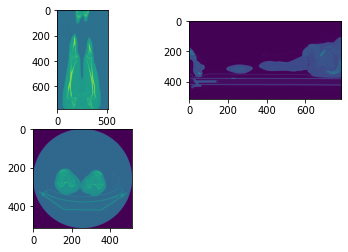

In [2]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import sys
import glob

# load the DICOM files
import os
PathDicom = "/data/Pat1/CT_scan/DICOM/PA000001/ST000001/SE000005"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".zip" not in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
# print(len(lstFilesDCM))
files = []
# print('glob: {}'.format(sys.argv[1]))
for fname in lstFilesDCM:
#     print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

# print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)
    else:
        skipcount = skipcount + 1

# print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)
print(len(slices))

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)
img_shape.append(len(slices))
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 3)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 1)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()

In [3]:
# np.average(img3d.ravel())

In [4]:
import copy
# # plot 3 orthogonal slices
# a1 = plt.subplot(2, 2, 1)
# my_array = copy.deepcopy(img3d[:, :, img_shape[2]//2])
# my_array[my_array <= 1500] = 0
# plt.imshow(my_array)

# a1.set_aspect(ax_aspect)
# a2 = plt.subplot(2, 2, 2)
# my_array = copy.deepcopy(img3d[:, :, img_shape[2]//2])
# my_array[my_array <= 2000] = 0
# plt.imshow(my_array)

# a2.set_aspect(ax_aspect)


In [5]:
# a3 = plt.subplot(2, 2, 1)
# my_array = copy.deepcopy(img3d[img_shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)
# my_array[my_array <= 1500] = 0
# plt.imshow(my_array)
# a3.set_aspect(ax_aspect)

# a2 = plt.subplot(2, 2, 2)
# my_array = copy.deepcopy(img3d[img_shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)
# my_array[my_array <= 2000] = 0
# plt.imshow(my_array)
# a2.set_aspect(ax_aspect)


In [6]:
array_3d = copy.deepcopy(img3d)
array_3d[array_3d <= 1500] = 0


In [7]:
# x, y, z = [], [], []

# for i, img2d in enumerate(img3d):
#     for j, img1d in enumerate(img2d):
#         for k, pixal in enumerate(img1d):
#             if pixal > 1500:
#                 x.append(int(i))
#                 y.append(int(j))
#                 z.append(int(k))

# x = np.array(x)
# y = np.array(y)
# z = np.array(z)

In [8]:
# import ipyvolume as ipv
# ipv.figure()
# ipv.scatter(x, y, z, marker='sphere')

# ipv.save('bone.html')


In [9]:
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def plot_3d(p, label=None):

    # Position the scan upright, 
    # so the head of the patient would be at the top facing the   
    # camera
    # p = image  # .transpose(2,1,0)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    # Fancy indexing: `verts[faces]` to generate a collection of    
    # triangles
    if label:
        verts, faces, _, _ = measure.marching_cubes_lewiner(label)
        mesh = Poly3DCollection(verts[faces], alpha=0.20)
        face_color = [0.45, 0.45, 0.75]
        mesh.set_facecolor(face_color)
        ax.add_collection3d(mesh)

    verts, faces, _, _ = measure.marching_cubes_lewiner(p)
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    plt.show()

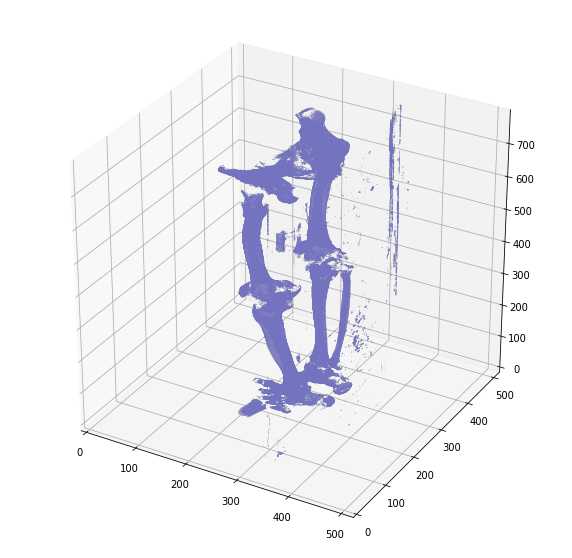

In [10]:
plot_3d(array_3d)

In [11]:
def recenter(csv_data):
    csv_data['x'] = csv_data['x'] + 200
    csv_data['y'] = csv_data['y'] + 200
    csv_data['z'] = csv_data['z'] + 200
    return csv_data

path_csv = '/data/Pat1/POD_JR_9060K_Landmarks_femur.csv'
import pandas as pd
data = pd.read_csv(path_csv, names=["Name", "x", "y", "z"])
data = recenter(data)
data

,Name,x,y,z
0,PCLOrigin,126.793300,224.939700,569.894100
1,femoralCenter,113.265800,203.149500,546.903100
2,greaterTrochanter,53.227700,211.263400,962.580800
3,hipCenter,104.847400,184.719100,959.975400
4,lateralCondyle,90.977900,213.863500,539.416500
5,lateralEpicondyle,71.690300,220.546600,564.459000
6,lateralPosteriorCondyle,91.063600,243.374100,561.026700
7,medialCondyle,143.109100,213.664600,539.387900
8,medialEpicondyle,158.638492,206.533736,566.837342
9,medialPosteriorCondyle,143.780700,241.472500,564.282800


In [12]:
for index, row in data.iterrows():
    print(row['x'], '-----', row['y'], '-----', row['z'])


126.7933 ----- 224.9397 ----- 569.8941
113.2658 ----- 203.1495 ----- 546.9031
53.2277 ----- 211.2634 ----- 962.5808
104.8474 ----- 184.7191 ----- 959.9754
90.9779 ----- 213.8635 ----- 539.4165
71.69030000000001 ----- 220.5466 ----- 564.4590000000001
91.0636 ----- 243.3741 ----- 561.0267
143.1091 ----- 213.6646 ----- 539.3879
158.63849240273208 ----- 206.53373591072682 ----- 566.837341836535
143.7807 ----- 241.4725 ----- 564.2828
158.5439317337273 ----- 211.910183748685 ----- 563.50762392606
83.9814 ----- 188.6257 ----- 760.6184
110.772 ----- 186.8431 ----- 556.392


In [14]:
mark_img = np.zeros(img_shape)
x = np.zeros(img_shape)

cude_size = 10
for i in range(-cude_size, cude_size):
    for j in range(-cude_size, cude_size):
        for k in range(-cude_size, cude_size):
            mark_img[i+400, j+400, 720+k] = 5200
            x[i+300, j+300, 320+k] = 5200

plot_3d(mark_img, x)

In [ ]:
# for index, row in df.iterrows():
#     print(row['x'], row['y'])


In [ ]:
# x = np.linspace(0, 512, 100)
# y = np.sin(x)*x
# print(len(x),max(y))